In [1]:
# Importing all the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
from sklearn import cross_validation
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import cross_val_score
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import log_loss

In [2]:
X_train = pd.read_csv('train_x.csv', index_col=0)
y_train = pd.read_csv('train_y.csv', header=None, usecols=(1,1))   

In [3]:
# Selecting the top variables 107 variables from the list of variables on the basis of VIF
cnts_vars_final = ['f_158','f_19','f_154','f_48','f_202','f_113','f_69','f_27','f_74','f_240','f_6','f_108','f_118',
                   'f_112','f_227','f_177','f_110','f_53','f_4','f_231','f_246','f_152','f_201','f_0','f_225','f_184',
                   'f_56','f_16','f_90','f_37','f_200','f_203','f_129','f_236','f_46','f_182','f_100','f_176','f_251',
                   'f_247','f_17','f_206','f_238','f_23','f_24','f_126','f_127','f_64','f_41','f_111','f_65','f_22',
                   'f_128','f_136','f_107','f_92','f_122','f_78','f_2','f_10','f_59','f_229','f_125','f_33','f_40',
                   'f_170','f_159','f_5','f_174','f_194','f_241','f_77','f_199','f_140','f_198','f_178','f_216',
                   'f_188','f_120','f_131','f_144','f_67','f_50','f_221','f_60','f_42','f_180','f_76','f_226',
                   'f_149','f_1','f_73','f_18','f_155','f_173','f_85','f_135','f_248','f_68','f_191','f_252',
                   'f_98','f_204','f_45','f_58','f_28','f_183']

In [4]:
cat_vars_final = list(pd.read_csv('cat_vars.csv')['0'])
#cat_vars_final = cat_vars_final[1:10]
var = cnts_vars_final
var.extend(cat_vars_final)
var

['f_158',
 'f_19',
 'f_154',
 'f_48',
 'f_202',
 'f_113',
 'f_69',
 'f_27',
 'f_74',
 'f_240',
 'f_6',
 'f_108',
 'f_118',
 'f_112',
 'f_227',
 'f_177',
 'f_110',
 'f_53',
 'f_4',
 'f_231',
 'f_246',
 'f_152',
 'f_201',
 'f_0',
 'f_225',
 'f_184',
 'f_56',
 'f_16',
 'f_90',
 'f_37',
 'f_200',
 'f_203',
 'f_129',
 'f_236',
 'f_46',
 'f_182',
 'f_100',
 'f_176',
 'f_251',
 'f_247',
 'f_17',
 'f_206',
 'f_238',
 'f_23',
 'f_24',
 'f_126',
 'f_127',
 'f_64',
 'f_41',
 'f_111',
 'f_65',
 'f_22',
 'f_128',
 'f_136',
 'f_107',
 'f_92',
 'f_122',
 'f_78',
 'f_2',
 'f_10',
 'f_59',
 'f_229',
 'f_125',
 'f_33',
 'f_40',
 'f_170',
 'f_159',
 'f_5',
 'f_174',
 'f_194',
 'f_241',
 'f_77',
 'f_199',
 'f_140',
 'f_198',
 'f_178',
 'f_216',
 'f_188',
 'f_120',
 'f_131',
 'f_144',
 'f_67',
 'f_50',
 'f_221',
 'f_60',
 'f_42',
 'f_180',
 'f_76',
 'f_226',
 'f_149',
 'f_1',
 'f_73',
 'f_18',
 'f_155',
 'f_173',
 'f_85',
 'f_135',
 'f_248',
 'f_68',
 'f_191',
 'f_252',
 'f_98',
 'f_204',
 'f_45',
 'f_58',

In [5]:
# function for xgboost
def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=y_train[1].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          metrics=['logloss'], early_stopping_rounds=early_stopping_rounds, show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], np.ravel(y_train),eval_metric='logloss')
        
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [6]:
# xgboost classifier
xgb1 = XGBRegressor(learning_rate =0.03, n_estimators=300, max_depth=2, reg_alpha = 0.005, min_child_weight=5, gamma=0.3,
                    colsample_bytree=0.8, subsample=0.8, reg_lambda = 1.2, max_delta_step=3,objective= 'reg:linear',
                    nthread=4, scale_pos_weight=1, seed=45, base_score=0.55)
# xgb1 = XGBRegressor( objective= 'reg:linear', nthread=4, reg_lambda=0.1, reg_alpha=0.12, seed=45, base_score=0.55)

Will train until cv error hasn't decreased in 50 rounds.
Stopping. Best iteration:
[33] cv-mean:-35.3682334	cv-std:7.04176937081


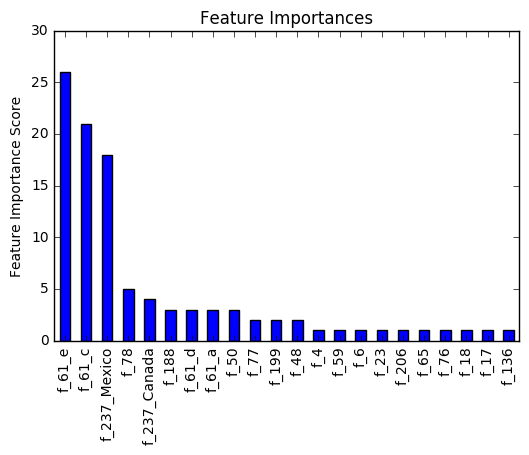

In [7]:
#Choose the predictors for xgboost and fit the model
predictors = var
modelfit(xgb1, X_train, predictors)

In [8]:
#T_train_xgb = xgb.DMatrix(X_train[var], y_train)
#params = {"objective": "reg:linear", "booster":"gblinear"}
#gbm = xgb.train(dtrain=T_train_xgb,params=params)

In [9]:
#X_test = pd.read_csv('test_.csv', index_col=0)
#X_test = X_test[var]
#Y_pred = gbm.predict(xgb.DMatrix(X_test))
#print Y_pred
#pd.DataFrame(Y_pred)

In [10]:
# Train 
from sklearn.metrics import mean_squared_error
y_predS = xgb1.predict(X_train[var])
print(mean_squared_error(y_train, y_predS))

25.870556446


In [11]:
# Tune tree pruning parameters: max_depth and min_child_weight
param_test1 = {
   'max_depth':[2, 3, 4, 5, 6],
    'min_child_weight':[1, 2, 3, 4, 5, 6, 10, 15, 100]
}

gsearch1 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.03, n_estimators=300, max_depth=2, reg_alpha = 0.005, 
                                                 min_child_weight=5, gamma=0.3,colsample_bytree=0.8, subsample=0.8, 
                                                 reg_lambda = 1.2, max_delta_step=3,objective= 'reg:linear',nthread=4, 
                                                 scale_pos_weight=1, seed=45, base_score=0.55 ),
                        param_grid = param_test1,scoring='mean_squared_error', n_jobs=4,iid=False, cv=3)

gsearch1.fit(X_train[var],np.ravel(y_train))
pd.Series(gsearch1.grid_scores_).to_csv('/home/pgoyal/Projects/app/gsresearch1.csv')

In [12]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: -25.79173, std: 1.06554, params: {'max_depth': 2, 'min_child_weight': 1},
  mean: -25.79143, std: 1.06806, params: {'max_depth': 2, 'min_child_weight': 2},
  mean: -25.78834, std: 1.07625, params: {'max_depth': 2, 'min_child_weight': 3},
  mean: -25.77967, std: 1.07114, params: {'max_depth': 2, 'min_child_weight': 4},
  mean: -25.78510, std: 1.07518, params: {'max_depth': 2, 'min_child_weight': 5},
  mean: -25.79414, std: 1.08182, params: {'max_depth': 2, 'min_child_weight': 6},
  mean: -25.77264, std: 1.07043, params: {'max_depth': 2, 'min_child_weight': 10},
  mean: -25.80502, std: 1.08110, params: {'max_depth': 2, 'min_child_weight': 15},
  mean: -25.77385, std: 1.05444, params: {'max_depth': 2, 'min_child_weight': 100},
  mean: -25.98863, std: 1.05106, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: -25.95940, std: 1.04144, params: {'max_depth': 3, 'min_child_weight': 2},
  mean: -25.96406, std: 1.05496, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: -25.

In [13]:
# Tune gamma
param_test1 = {
'gamma':[i/10.0 for i in range(0,5)]
}

gsearch1 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.03, n_estimators=300, max_depth=2, reg_alpha = 0.005, 
                                                 min_child_weight=10, gamma=0.3,colsample_bytree=0.8, subsample=0.8, 
                                                 reg_lambda = 1.2, max_delta_step=3,objective= 'reg:linear',nthread=4, 
                                                 scale_pos_weight=1, seed=45, base_score=0.55 ),
                        param_grid = param_test1,scoring='mean_squared_error', n_jobs=4,iid=False, cv=3)

gsearch1.fit(X_train[var],np.ravel(y_train))
pd.Series(gsearch1.grid_scores_).to_csv('/home/pgoyal/Projects/app/gsresearch2.csv')

In [14]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: -25.77264, std: 1.07043, params: {'gamma': 0.0},
  mean: -25.77264, std: 1.07043, params: {'gamma': 0.1},
  mean: -25.77264, std: 1.07043, params: {'gamma': 0.2},
  mean: -25.77264, std: 1.07043, params: {'gamma': 0.3},
  mean: -25.77264, std: 1.07043, params: {'gamma': 0.4}],
 {'gamma': 0.0},
 -25.772637090199737)

In [15]:
# Tune sample size and number of columns for a single tree
param_test1 = {
'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(4,10)]
}

gsearch1 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.03, n_estimators=300, max_depth=2, reg_alpha = 0.005, 
                                                 min_child_weight=10, gamma=0.0,colsample_bytree=0.8, subsample=0.8, 
                                                 reg_lambda = 1.2, max_delta_step=3,objective= 'reg:linear',nthread=4, 
                                                 scale_pos_weight=1, seed=45, base_score=0.55 ),
                        param_grid = param_test1,scoring='mean_squared_error', n_jobs=4,iid=False, cv=3)
gsearch1.fit(X_train[var],np.ravel(y_train))
pd.Series(gsearch1.grid_scores_).to_csv('/home/pgoyal/Projects/app/gsresearch3.csv')

In [16]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: -25.82861, std: 1.14110, params: {'subsample': 0.6, 'colsample_bytree': 0.4},
  mean: -25.76952, std: 1.15577, params: {'subsample': 0.7, 'colsample_bytree': 0.4},
  mean: -25.70730, std: 1.10361, params: {'subsample': 0.8, 'colsample_bytree': 0.4},
  mean: -25.75560, std: 1.07990, params: {'subsample': 0.9, 'colsample_bytree': 0.4},
  mean: -25.77770, std: 1.09001, params: {'subsample': 0.6, 'colsample_bytree': 0.5},
  mean: -25.75859, std: 1.14175, params: {'subsample': 0.7, 'colsample_bytree': 0.5},
  mean: -25.74656, std: 1.12404, params: {'subsample': 0.8, 'colsample_bytree': 0.5},
  mean: -25.76190, std: 1.11114, params: {'subsample': 0.9, 'colsample_bytree': 0.5},
  mean: -25.82250, std: 1.08901, params: {'subsample': 0.6, 'colsample_bytree': 0.6},
  mean: -25.78170, std: 1.13774, params: {'subsample': 0.7, 'colsample_bytree': 0.6},
  mean: -25.76962, std: 1.05898, params: {'subsample': 0.8, 'colsample_bytree': 0.6},
  mean: -25.79996, std: 1.09551, params: {'subsample':

In [17]:
# Tune regularization parameter: reg_alpha
param_test1 = {
'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

gsearch1 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.03, n_estimators=300, max_depth=2, reg_alpha = 0.005, 
                                                 min_child_weight=10, gamma=0.0,colsample_bytree=0.4, subsample=0.8, 
                                                 reg_lambda = 1.2, max_delta_step=3,objective= 'reg:linear',nthread=4, 
                                                 scale_pos_weight=1, seed=45, base_score=0.55 ),
                        param_grid = param_test1,scoring='mean_squared_error', n_jobs=4,iid=False, cv=3)
gsearch1.fit(X_train[var],np.ravel(y_train))
pd.Series(gsearch1.grid_scores_).to_csv('/home/pgoyal/Projects/app/gsresearch4.csv')

In [18]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: -25.70730, std: 1.10361, params: {'reg_alpha': 1e-05},
  mean: -25.70729, std: 1.10361, params: {'reg_alpha': 0.01},
  mean: -25.70405, std: 1.11716, params: {'reg_alpha': 0.1},
  mean: -25.72755, std: 1.11088, params: {'reg_alpha': 1},
  mean: -25.68946, std: 1.14679, params: {'reg_alpha': 100}],
 {'reg_alpha': 100},
 -25.689462640705887)

In [19]:
# Tune regularization parameters: reg_lambda
param_test1 = {
    'reg_lambda':[0, 1, 1.1, 1.2, 1.5, 2, 3, 5]
}

gsearch1 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.03, n_estimators=300, max_depth=2, reg_alpha = 100, 
                                                 min_child_weight=10, gamma=0.0,colsample_bytree=0.4, subsample=0.8, 
                                                 reg_lambda = 1.2, max_delta_step=3,objective= 'reg:linear',nthread=4, 
                                                 scale_pos_weight=1, seed=45, base_score=0.55 ),
                        param_grid = param_test1,scoring='mean_squared_error', n_jobs=4,iid=False, cv=3)
gsearch1.fit(X_train[var],np.ravel(y_train))
pd.Series(gsearch1.grid_scores_).to_csv('/home/pgoyal/Projects/app/gsresearch5.csv')

In [20]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: -25.68789, std: 1.15678, params: {'reg_lambda': 0},
  mean: -25.68936, std: 1.14659, params: {'reg_lambda': 1},
  mean: -25.69229, std: 1.15076, params: {'reg_lambda': 1.1},
  mean: -25.68946, std: 1.14679, params: {'reg_lambda': 1.2},
  mean: -25.68709, std: 1.14858, params: {'reg_lambda': 1.5},
  mean: -25.68643, std: 1.14776, params: {'reg_lambda': 2},
  mean: -25.68377, std: 1.15460, params: {'reg_lambda': 3},
  mean: -25.68202, std: 1.16029, params: {'reg_lambda': 5}],
 {'reg_lambda': 5},
 -25.682023816949737)

In [21]:
param_test1 = {
'max_delta_step':[0, 1, 2, 3, 4, 5, 10, 100]
}

gsearch1 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.03, n_estimators=300, max_depth=2, reg_alpha = 100, 
                                                 min_child_weight=10, gamma=0.0,colsample_bytree=0.4, subsample=0.8, 
                                                 reg_lambda = 5, max_delta_step=3,objective= 'reg:linear',nthread=4, 
                                                 scale_pos_weight=1, seed=45, base_score=0.55 ),
                        param_grid = param_test1,scoring='mean_squared_error', n_jobs=4,iid=False, cv=3)
gsearch1.fit(X_train[var],np.ravel(y_train))
pd.Series(gsearch1.grid_scores_).to_csv('/home/pgoyal/Projects/app/gsresearch6.csv')

In [22]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: -25.68202, std: 1.16029, params: {'max_delta_step': 0},
  mean: -25.66817, std: 1.16142, params: {'max_delta_step': 1},
  mean: -25.68213, std: 1.16021, params: {'max_delta_step': 2},
  mean: -25.68202, std: 1.16029, params: {'max_delta_step': 3},
  mean: -25.68202, std: 1.16029, params: {'max_delta_step': 4},
  mean: -25.68202, std: 1.16029, params: {'max_delta_step': 5},
  mean: -25.68202, std: 1.16029, params: {'max_delta_step': 10},
  mean: -25.68202, std: 1.16029, params: {'max_delta_step': 100}],
 {'max_delta_step': 1},
 -25.668174002456993)

In [23]:
param_test1 = {
'scale_pos_weight':[0, 1, 2, 5, 10, 50, 100]
}
gsearch1 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.03, n_estimators=300, max_depth=2, reg_alpha = 100, 
                                                 min_child_weight=10, gamma=0.0,colsample_bytree=0.4, subsample=0.8, 
                                                 reg_lambda = 5, max_delta_step=1,objective= 'reg:linear',nthread=4, 
                                                 scale_pos_weight=1, seed=45, base_score=0.55 ),
                        param_grid = param_test1,scoring='mean_squared_error', n_jobs=4,iid=False, cv=3)
gsearch1.fit(X_train[var],np.ravel(y_train))
pd.Series(gsearch1.grid_scores_).to_csv('/home/pgoyal/Projects/app/gsresearch7.csv')

In [24]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: -25.66817, std: 1.16142, params: {'scale_pos_weight': 0},
  mean: -25.66817, std: 1.16142, params: {'scale_pos_weight': 1},
  mean: -25.66817, std: 1.16142, params: {'scale_pos_weight': 2},
  mean: -25.66817, std: 1.16142, params: {'scale_pos_weight': 5},
  mean: -25.66817, std: 1.16142, params: {'scale_pos_weight': 10},
  mean: -25.66817, std: 1.16142, params: {'scale_pos_weight': 50},
  mean: -25.66817, std: 1.16142, params: {'scale_pos_weight': 100}],
 {'scale_pos_weight': 0},
 -25.668174002456993)

In [25]:
param_test1 = {
'learning_rate':[0.01, 0.03, 0.05], 
'n_estimators':[250, 300, 350, 500, 700]
}
gsearch1 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.03, n_estimators=300, max_depth=2, reg_alpha = 100, 
                                                 min_child_weight=10, gamma=0.0,colsample_bytree=0.4, subsample=0.8, 
                                                 reg_lambda = 5, max_delta_step=1,objective= 'reg:linear',nthread=4, 
                                                 scale_pos_weight=0, seed=45, base_score=0.55 ),
                        param_grid = param_test1,scoring='mean_squared_error', n_jobs=4,iid=False, cv=3)
gsearch1.fit(X_train[var],np.ravel(y_train))
pd.Series(gsearch1.grid_scores_).to_csv('/home/pgoyal/Projects/gsresearch8.csv')

In [26]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: -25.90971, std: 1.20954, params: {'n_estimators': 250, 'learning_rate': 0.01},
  mean: -25.78555, std: 1.19181, params: {'n_estimators': 300, 'learning_rate': 0.01},
  mean: -25.70560, std: 1.18563, params: {'n_estimators': 350, 'learning_rate': 0.01},
  mean: -25.62100, std: 1.16706, params: {'n_estimators': 500, 'learning_rate': 0.01},
  mean: -25.63779, std: 1.15366, params: {'n_estimators': 700, 'learning_rate': 0.01},
  mean: -25.65487, std: 1.16351, params: {'n_estimators': 250, 'learning_rate': 0.03},
  mean: -25.66817, std: 1.16142, params: {'n_estimators': 300, 'learning_rate': 0.03},
  mean: -25.70001, std: 1.16653, params: {'n_estimators': 350, 'learning_rate': 0.03},
  mean: -25.81476, std: 1.16923, params: {'n_estimators': 500, 'learning_rate': 0.03},
  mean: -26.03087, std: 1.12450, params: {'n_estimators': 700, 'learning_rate': 0.03},
  mean: -25.80012, std: 1.18723, params: {'n_estimators': 250, 'learning_rate': 0.05},
  mean: -25.85307, std: 1.18590, params: {'

Will train until cv error hasn't decreased in 50 rounds.
Stopping. Best iteration:
[259] cv-mean:-35.0053724	cv-std:7.66403812797


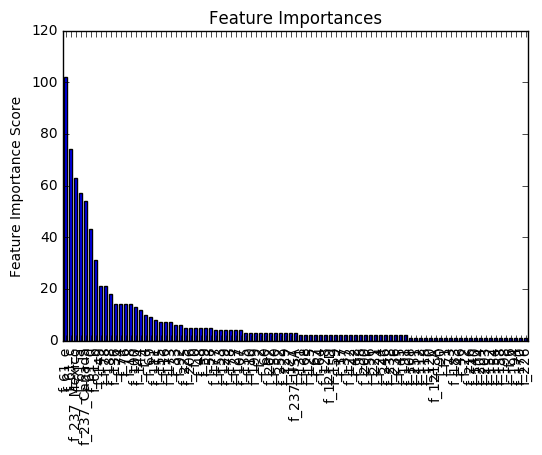

In [27]:
# xgboost classifier
xgb1 = XGBRegressor(learning_rate =0.01, n_estimators=500, max_depth=2, reg_alpha = 100, min_child_weight=10, 
                    gamma=0.0,colsample_bytree=0.4, subsample=0.8, reg_lambda = 5, max_delta_step=1,
                    objective= 'reg:linear',nthread=4, scale_pos_weight=0, seed=45, base_score=0.55 )
#Choose the predictors for xgboost and fit the model
predictors = var
modelfit(xgb1, X_train, predictors)

In [28]:
feat_imp = pd.Series(xgb1.booster().get_fscore()).sort_values(ascending=False)

In [29]:
feat_imp

f_61_e          102
f_61_c           74
f_237_Mexico     63
f_61_a           57
f_237_Canada     54
f_61_d           43
f_61_b           31
f_149            21
f_78             21
f_188            18
f_136            14
f_74             14
f_76             14
f_18             14
f_100            13
f_144            12
f_4              10
f_69              9
f_111             8
f_155             7
f_16              7
f_173             7
f_33              6
f_92              6
f_225             5
f_206             5
f_0               5
f_48              5
f_59              5
f_58              5
               ... 
f_24              2
f_246             2
f_238             2
f_236             2
f_45              2
f_191             2
f_108             1
f_251             1
f_112             1
f_118             1
f_120             1
f_121_A           1
f_90              1
f_1               1
f_73              1
f_183             1
f_46              1
f_22              1
f_216             1


In [30]:
pd.DataFrame(feat_imp).to_csv('/home/pgoyal/Projects/app/feat_imp.csv')

In [31]:
y_predS = xgb1.predict(X_train[var])
print(mean_squared_error(y_train, y_predS))

25.4838990105


In [32]:
# Save the model
from sklearn.externals import joblib
joblib.dump(xgb1, '/home/pgoyal/Projects/app/xgb_500_logloss.pkl')

['/home/pgoyal/Projects/app/xgb_500_logloss.pkl']